============================================================
### 03 - MODELISATION 
============================================================

#### 1. PRÉPARATION PRÉ-MODÉLISATION

##### 1.1 Chargement des Datasets

In [5]:
# ============= IMPORTS =============
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
import joblib

In [6]:
# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [7]:
# Chargement des trois versions normalisées
df_dropna = pd.read_csv('../data/df_dropna_normalized.csv')
df_median_mode = pd.read_csv('../data/df_median_mode_normalized.csv')
df_knn = pd.read_csv('../data/df_knn_normalized.csv')

# Vérification des dimensions
print(f"df_dropna shape: {df_dropna.shape}")
print(f"df_median_mode shape: {df_median_mode.shape}")
print(f"df_knn shape: {df_knn.shape}")

df_dropna shape: (19021, 39)
df_median_mode shape: (20000, 39)
df_knn shape: (20000, 39)


In [8]:
# Liste des datasets
datasets = {
    'dropna': df_dropna,
    'median_mode': df_median_mode,
    'knn': df_knn
}

# Suppression de la colonne cheveux si elle existe
for name, df in datasets.items():
    if 'cheveux' in df.columns:
        df.drop('cheveux', axis=1, inplace=True)
        print(f"Variable 'cheveux' supprimée de {name}")

##### 1.3 Séparation Features / Cible

In [9]:
# Dictionnaire pour stocker les données séparées
data_splits = {}

for name, df in datasets.items():
    # Séparation X (features) et y (cible)
    X = df.drop('embauche', axis=1)
    y = df['embauche']
    
    # Vérification de l'équilibre des classes
    print(f"\n{name.upper()} - Distribution de la cible:")
    print(y.value_counts(normalize=True))
    
    data_splits[name] = {'X': X, 'y': y}


DROPNA - Distribution de la cible:
embauche
0    0.885442
1    0.114558
Name: proportion, dtype: float64

MEDIAN_MODE - Distribution de la cible:
embauche
0    0.8854
1    0.1146
Name: proportion, dtype: float64

KNN - Distribution de la cible:
embauche
0    0.8854
1    0.1146
Name: proportion, dtype: float64


##### 1.4 Split Train/Test Stratifié

In [10]:
from sklearn.model_selection import train_test_split

# Paramètres du split
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Création des splits pour chaque dataset
train_test_data = {}

for name, data in data_splits.items():
    X_train, X_test, y_train, y_test = train_test_split(
        data['X'], 
        data['y'], 
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE,
        stratify=data['y']
    )
    
    train_test_data[name] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test
    }
    
    print(f"\n{name.upper()}:")
    print(f"  Train set: {X_train.shape[0]} samples")
    print(f"  Test set: {X_test.shape[0]} samples")
    print(f"  Ratio embauche train: {y_train.mean():.3f}")
    print(f"  Ratio embauche test: {y_test.mean():.3f}")


DROPNA:
  Train set: 15216 samples
  Test set: 3805 samples
  Ratio embauche train: 0.115
  Ratio embauche test: 0.115

MEDIAN_MODE:
  Train set: 16000 samples
  Test set: 4000 samples
  Ratio embauche train: 0.115
  Ratio embauche test: 0.115

KNN:
  Train set: 16000 samples
  Test set: 4000 samples
  Ratio embauche train: 0.115
  Ratio embauche test: 0.115


##### 1.5 Vérifications finales

In [11]:
# Vérification absence de valeurs manquantes
for name, splits in train_test_data.items():
    missing_train = splits['X_train'].isnull().sum().sum()
    missing_test = splits['X_test'].isnull().sum().sum()
    print(f"{name}: Train NaN={missing_train}, Test NaN={missing_test}")

# Vérification absence de fuite de données
print("\nVérification de la séparation train/test (pas de chevauchement)")
for name, splits in train_test_data.items():
    intersection = set(splits['X_train'].index) & set(splits['X_test'].index)
    print(f"{name}: Intersection train/test = {len(intersection)}")

dropna: Train NaN=2, Test NaN=0
median_mode: Train NaN=1, Test NaN=1
knn: Train NaN=617, Test NaN=113

Vérification de la séparation train/test (pas de chevauchement)
dropna: Intersection train/test = 0
median_mode: Intersection train/test = 0
knn: Intersection train/test = 0


**gestion des valeurs manquantes train/test**

In [12]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


**Methode 1 : imputaions par fontion**

In [13]:
# fonctin de traitement
def preprocess_data(X_train, X_test, method="median"):

    # Copier pour éviter les effets de bord
    X_train = X_train.copy()
    X_test = X_test.copy()

    # Conversion explicite des booléens → int
    bool_cols = X_train.select_dtypes(include=["bool"]).columns
    X_train[bool_cols] = X_train[bool_cols].astype(int)
    X_test[bool_cols] = X_test[bool_cols].astype(int)

    # Détection des types
    num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = X_train.select_dtypes(include=["object"]).columns

    # Imputers
    if method == "knn":
        num_imputer = KNNImputer(n_neighbors=5)
    else:
        num_imputer = SimpleImputer(strategy="median")

    cat_imputer = SimpleImputer(strategy="most_frequent")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_imputer, num_cols),
            ("cat", cat_imputer, cat_cols)
        ],
        remainder="drop"
    )

    X_train_clean = preprocessor.fit_transform(X_train)
    X_test_clean = preprocessor.transform(X_test)

    return X_train_clean, X_test_clean


**Méthode 2 : Suprimer les valeurs manquates**

In [14]:
"""
def preprocess_data(X_train, X_test, y_train=None, y_test=None):
    
    Supprime les lignes contenant des valeurs manquantes.
    Synchronise les suppressions avec les labels si fournis.
    
    Parameters:
    -----------
    X_train : DataFrame
        Données d'entraînement
    X_test : DataFrame
        Données de test
    y_train : Series, optional
        Labels d'entraînement
    y_test : Series, optional
        Labels de test
        
    Returns:
    --------
    Si y_train et y_test sont fournis :
        X_train_clean, X_test_clean, y_train_clean, y_test_clean
    Sinon :
        X_train_clean, X_test_clean
    
    
    # Copier pour éviter les effets de bord
    X_train_clean = X_train.copy()
    X_test_clean = X_test.copy()
    
    # Traitement de l'ensemble d'entraînement
    if y_train is not None:
        # Identifier les lignes sans valeurs manquantes
        mask_train = ~X_train_clean.isna().any(axis=1)
        X_train_clean = X_train_clean[mask_train]
        y_train_clean = y_train[mask_train].reset_index(drop=True)
    else:
        X_train_clean = X_train_clean.dropna()
    
    # Traitement de l'ensemble de test
    if y_test is not None:
        # Identifier les lignes sans valeurs manquantes
        mask_test = ~X_test_clean.isna().any(axis=1)
        X_test_clean = X_test_clean[mask_test]
        y_test_clean = y_test[mask_test].reset_index(drop=True)
    else:
        X_test_clean = X_test_clean.dropna()
    
    # Réinitialiser les index
    X_train_clean = X_train_clean.reset_index(drop=True)
    X_test_clean = X_test_clean.reset_index(drop=True)
    
    # Retourner avec ou sans labels
    if y_train is not None and y_test is not None:
        return X_train_clean, X_test_clean, y_train_clean, y_test_clean
    else:
        return X_train_clean, X_test_clean
"""

"\ndef preprocess_data(X_train, X_test, y_train=None, y_test=None):\n    \n    Supprime les lignes contenant des valeurs manquantes.\n    Synchronise les suppressions avec les labels si fournis.\n    \n    Parameters:\n    -----------\n    X_train : DataFrame\n        Données d'entraînement\n    X_test : DataFrame\n        Données de test\n    y_train : Series, optional\n        Labels d'entraînement\n    y_test : Series, optional\n        Labels de test\n        \n    Returns:\n    --------\n    Si y_train et y_test sont fournis :\n        X_train_clean, X_test_clean, y_train_clean, y_test_clean\n    Sinon :\n        X_train_clean, X_test_clean\n    \n    \n    # Copier pour éviter les effets de bord\n    X_train_clean = X_train.copy()\n    X_test_clean = X_test.copy()\n    \n    # Traitement de l'ensemble d'entraînement\n    if y_train is not None:\n        # Identifier les lignes sans valeurs manquantes\n        mask_train = ~X_train_clean.isna().any(axis=1)\n        X_train_clean =

In [15]:
## Apllication méthode 1
clean_data = {}

for name, splits in train_test_data.items():
    method = "knn" if name.lower() == "knn" else "median"

    X_train_clean, X_test_clean = preprocess_data(
        splits["X_train"],
        splits["X_test"]
        #method=method
    )

    clean_data[name] = {
        "X_train": X_train_clean,
        "X_test": X_test_clean,
        "y_train": splits["y_train"],
        "y_test": splits["y_test"]
    }


In [110]:
"""
## Application méthode 2
clean_data = {}

for name, splits in train_test_data.items():
    X_train_clean, X_test_clean, y_train_clean, y_test_clean = preprocess_data(
        splits["X_train"],
        splits["X_test"],
        splits["y_train"],
        splits["y_test"]
    )

    clean_data[name] = {
        "X_train": X_train_clean,
        "X_test": X_test_clean,
        "y_train": y_train_clean,
        "y_test": y_test_clean
    }
"""

'\n## Application méthode 2\nclean_data = {}\n\nfor name, splits in train_test_data.items():\n    X_train_clean, X_test_clean, y_train_clean, y_test_clean = preprocess_data(\n        splits["X_train"],\n        splits["X_test"],\n        splits["y_train"],\n        splits["y_test"]\n    )\n\n    clean_data[name] = {\n        "X_train": X_train_clean,\n        "X_test": X_test_clean,\n        "y_train": y_train_clean,\n        "y_test": y_test_clean\n    }\n'

In [16]:
for name, data in clean_data.items():
    print(
        f"{name}: "
        f"Train NaN={pd.isnull(data['X_train']).sum()}, "
        f"Test NaN={pd.isnull(data['X_test']).sum()}"
    )


dropna: Train NaN=0, Test NaN=0
median_mode: Train NaN=0, Test NaN=0
knn: Train NaN=0, Test NaN=0


#### 2. STRATÉGIE DE MODÉLISATION

##### 2.1 Sélection des Algorithmes

**Logistic Regression**

Modèle baseline rapide et interprétable
Gère bien le déséquilibre via class_weight
Bonne référence pour évaluer les gains des modèles complexes


**K-Nearest Neighbors (KNN)**

Algorithme non paramétrique, sensible à la normalisation (déjà appliquée)
Utile pour capturer des patterns locaux
Adaptation au déséquilibre via pondération


**Decision Tree**

Capture facilement les interactions non linéaires
Interprétabilité élevée (visualisation de l'arbre)
Base pour comprendre les ensembles qui suivent


**Random Forest**

Ensemble robuste, gère bien les interactions
Réduit le surapprentissage du Decision Tree
Fournit l'importance des features


**Gradient Boosting (XGBoost)**

Souvent le meilleur performer sur données tabulaires
Optimisation itérative des erreurs
Hyperparamètres scale_pos_weight pour le déséquilibre


**Support Vector Machine (SVM)**

Kernel RBF pour capturer les non-linéarités
Robuste dans les espaces de haute dimension
Gestion du déséquilibre via class_weight

##### 2.2 Gestion du Déséquilibre de Classes

In [112]:
# Calcul du ratio de déséquilibre
ratio_desequilibre = (y_train.value_counts()[0] / y_train.value_counts()[1])
print(f"Ratio déséquilibre (Non-embauchés/Embauchés): {ratio_desequilibre:.2f}")

# Configuration pour XGBoost
scale_pos_weight = ratio_desequilibre

Ratio déséquilibre (Non-embauchés/Embauchés): 7.72


#### 3. CONFIGURATION ET ENTRAÎNEMENT DES MODÈLES

##### 3.1 Initialisation des Modèles

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import time

In [114]:

# Dictionnaire des modèles avec leurs hyperparamètres initiaux
models_config = {
    'Logistic_Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE
    ),
    
    'KNN': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'  # Pondération par distance
    ),
    
    'Decision_Tree': DecisionTreeClassifier(
        class_weight='balanced',
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=RANDOM_STATE
    ),
    
    'Random_Forest': RandomForestClassifier(
        n_estimators=100,
        class_weight='balanced',
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100,
        scale_pos_weight=scale_pos_weight,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='logloss'
    ),
    
    'SVM': SVC(
        kernel='rbf',
        class_weight='balanced',
        probability=True,  # Nécessaire pour ROC-AUC
        random_state=RANDOM_STATE
    )
}

##### 3.2 Entraînement des Modèles

In [115]:
trained_models = {}

for dataset_name in clean_data:
    print(f"\n{'='*60}")
    print(f"ENTRAÎNEMENT SUR DATASET: {dataset_name.upper()}")
    print(f"{'='*60}")
    
    trained_models[dataset_name] = {}

    # DONNÉES PROPRES
    X_train = clean_data[dataset_name]['X_train']
    y_train = clean_data[dataset_name]['y_train']

    for model_name, model in models_config.items():
        print(f"\nEntraînement de {model_name}...")

        start_time = time.time()

        model.fit(X_train, y_train)

        elapsed_time = time.time() - start_time

        trained_models[dataset_name][model_name] = {
            'model': model,
            'training_time': elapsed_time
        }

        print(f"  Terminé en {elapsed_time:.2f} secondes")


ENTRAÎNEMENT SUR DATASET: DROPNA

Entraînement de Logistic_Regression...
  Terminé en 2.87 secondes

Entraînement de KNN...
  Terminé en 0.00 secondes

Entraînement de Decision_Tree...
  Terminé en 0.30 secondes

Entraînement de Random_Forest...
  Terminé en 1.64 secondes

Entraînement de XGBoost...
  Terminé en 0.47 secondes

Entraînement de SVM...
  Terminé en 221.60 secondes

ENTRAÎNEMENT SUR DATASET: MEDIAN_MODE

Entraînement de Logistic_Regression...
  Terminé en 2.85 secondes

Entraînement de KNN...
  Terminé en 0.00 secondes

Entraînement de Decision_Tree...
  Terminé en 0.31 secondes

Entraînement de Random_Forest...
  Terminé en 1.67 secondes

Entraînement de XGBoost...
  Terminé en 0.50 secondes

Entraînement de SVM...
  Terminé en 225.01 secondes

ENTRAÎNEMENT SUR DATASET: KNN

Entraînement de Logistic_Regression...
  Terminé en 2.48 secondes

Entraînement de KNN...
  Terminé en 0.01 secondes

Entraînement de Decision_Tree...
  Terminé en 0.36 secondes

Entraînement de Rand

##### 4. ÉVALUATION DES PERFORMANCES

##### 4.1 Import des Métriques

In [116]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    matthews_corrcoef
)


##### 4.2 Fonction d'Évaluation Complète

In [117]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, dataset_name):
    """
    Évalue un modèle :
    - TRAIN : uniquement métriques
    - TEST  : métriques + prédictions + probabilités + matrice de confusion
    """

    # ======================
    # ÉVALUATION TRAIN
    # ======================
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None

    train_metrics = {
        "Model": model_name,
        "Dataset": dataset_name,
        "Set": "Train",
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1_Score": f1_score(y_train, y_train_pred),
        "MCC": matthews_corrcoef(y_train, y_train_pred),
        "ROC_AUC": roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else None
    }

    # ======================
    # ÉVALUATION TEST
    # ======================
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    test_metrics = {
        "Model": model_name,
        "Dataset": dataset_name,
        "Set": "Test",
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1_Score": f1_score(y_test, y_test_pred),
        "MCC": matthews_corrcoef(y_test, y_test_pred),
        "ROC_AUC": roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else None
    }

    cm_test = confusion_matrix(y_test, y_test_pred)

    return {
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "test_predictions": y_test_pred,
        "test_probabilities": y_test_proba,
        "confusion_matrix": cm_test
    }


##### 4.3 Évaluation de Tous les Modèles

In [118]:
# Stockage des résultats
all_results = []
all_predictions = {}
all_confusion_matrices = {}

for dataset_name in ['dropna', 'median_mode', 'knn']:
    print(f"\n{'='*60}")
    print(f"ÉVALUATION SUR DATASET: {dataset_name.upper()}")
    print(f"{'='*60}")

    # Données propres
    X_train = clean_data[dataset_name]['X_train']
    y_train = clean_data[dataset_name]['y_train']
    X_test = clean_data[dataset_name]['X_test']
    y_test = clean_data[dataset_name]['y_test']

    all_predictions[dataset_name] = {}
    all_confusion_matrices[dataset_name] = {}

    for model_name, model_dict in trained_models[dataset_name].items():
        model = model_dict['model']
        training_time = model_dict['training_time']

        # Évaluation complète
        results = evaluate_model(
            model=model,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            model_name=model_name,
            dataset_name=dataset_name
        )

        # Ajout du temps d'entraînement
        results["train_metrics"]["Training_Time"] = training_time
        results["test_metrics"]["Training_Time"] = training_time

        # Stockage global
        all_results.append(results["train_metrics"])
        all_results.append(results["test_metrics"])

        all_predictions[dataset_name][model_name] = {
            "y_pred": results["test_predictions"],
            "y_proba": results["test_probabilities"]
        }

        all_confusion_matrices[dataset_name][model_name] = results["confusion_matrix"]

        # Affichage résumé
        print(f"\n{model_name}:")
        print(f"  Train F1 : {results['train_metrics']['F1_Score']:.4f}")
        print(f"  Test  F1 : {results['test_metrics']['F1_Score']:.4f}")
        print(f"  Test Recall : {results['test_metrics']['Recall']:.4f}")
        print(f"  Test Precision : {results['test_metrics']['Precision']:.4f}")
        print(
            f"  Test ROC-AUC : {results['test_metrics']['ROC_AUC']:.4f}"
            if results['test_metrics']['ROC_AUC'] is not None
            else "  Test ROC-AUC : N/A"
        )



ÉVALUATION SUR DATASET: DROPNA

Logistic_Regression:
  Train F1 : 0.2542
  Test  F1 : 0.2569
  Test Recall : 0.6399
  Test Precision : 0.1607
  Test ROC-AUC : 0.6484

KNN:
  Train F1 : 0.8787
  Test  F1 : 0.8682
  Test Recall : 0.8005
  Test Precision : 0.9484
  Test ROC-AUC : 0.9286

Decision_Tree:
  Train F1 : 0.3670
  Test  F1 : 0.3706
  Test Recall : 0.8486
  Test Precision : 0.2370
  Test ROC-AUC : 0.8280

Random_Forest:
  Train F1 : 0.6603
  Test  F1 : 0.6944
  Test Recall : 0.8028
  Test Precision : 0.6119
  Test ROC-AUC : 0.9364

XGBoost:
  Train F1 : 0.4948
  Test  F1 : 0.5104
  Test Recall : 0.8761
  Test Precision : 0.3600
  Test ROC-AUC : 0.9142

SVM:
  Train F1 : 0.2152
  Test  F1 : 0.2185
  Test Recall : 0.8532
  Test Precision : 0.1253
  Test ROC-AUC : 0.5382

ÉVALUATION SUR DATASET: MEDIAN_MODE

Logistic_Regression:
  Train F1 : 0.2560
  Test  F1 : 0.2511
  Test Recall : 0.6376
  Test Precision : 0.1563
  Test ROC-AUC : 0.6471

KNN:
  Train F1 : 0.9910
  Test  F1 : 0.0

##### 4.4 Création du DataFrame de Résultats


In [119]:
# Conversion en DataFrame
results_df = pd.DataFrame(all_results)

# Ordre logique des colonnes
column_order = [
    'Dataset', 'Model', 'Set',
    'F1_Score', 'Recall', 'Precision',
    'Accuracy', 'ROC_AUC', 'MCC',
    'Training_Time'
]

results_df = results_df[column_order]

# Tri : Test d’abord, puis meilleur F1-score
results_df = results_df.sort_values(
    by=['Set', 'F1_Score'],
    ascending=[True, False]
).reset_index(drop=True)

# Arrondir pour lisibilité
results_df[['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'MCC']] = \
    results_df[['Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'MCC']].round(4)

# ===============================
# AFFICHAGE PROPRE
# ===============================
print("\n" + "=" * 90)
print("TABLEAU RÉCAPITULATIF DES PERFORMANCES")
print("=" * 90)
print(results_df.to_string(index=False))
print("=" * 90)

# ===============================
# SAUVEGARDE
# ===============================
results_df.to_csv("../results/model_evaluation_results.csv", index=False)
print("\nRésultats sauvegardés dans 'model_evaluation_results.csv'")



TABLEAU RÉCAPITULATIF DES PERFORMANCES
    Dataset               Model   Set  F1_Score  Recall  Precision  Accuracy  ROC_AUC    MCC  Training_Time
     dropna                 KNN  Test    0.8682  0.8005     0.9484    0.9721   0.9286 0.8565       0.004999
     dropna       Random_Forest  Test    0.6944  0.8028     0.6119    0.9191   0.9364 0.6567       1.643759
     dropna             XGBoost  Test    0.5104  0.8761     0.3600    0.8074   0.9142 0.4792       0.474519
     dropna       Decision_Tree  Test    0.3706  0.8486     0.2370    0.6696   0.8280 0.3206       0.304003
        knn       Random_Forest  Test    0.3542  0.3581     0.3504    0.8505   0.7455 0.2697       2.421849
median_mode       Random_Forest  Test    0.3531  0.3581     0.3482    0.8498   0.7468 0.2681       1.669989
        knn             XGBoost  Test    0.3470  0.5721     0.2490    0.7535   0.7483 0.2524       0.485002
median_mode             XGBoost  Test    0.3463  0.5742     0.2479    0.7518   0.7487 0.2517    

####  5. ANALYSE COMPARATIVE ET SÉLECTION DES MEILLEURS MODÈLES

##### 5.1 Identification des 3 Meilleurs Modèles

In [120]:
# Sélection des 3 meilleurs selon le F1-Score
top_3_models = results_df.head(3).copy()

print("\n" + "="*80)
print("TOP 3 MODÈLES SELON LE F1-SCORE")
print("="*80)
print(top_3_models.to_string(index=False))

# Extraction des informations pour sauvegarde ultérieure
best_models_info = []
for idx, row in top_3_models.iterrows():
    best_models_info.append({
        'rank': idx + 1,
        'dataset': row['Dataset'],
        'model_name': row['Model'],
        'f1_score': row['F1_Score']
    })


TOP 3 MODÈLES SELON LE F1-SCORE
Dataset         Model  Set  F1_Score  Recall  Precision  Accuracy  ROC_AUC    MCC  Training_Time
 dropna           KNN Test    0.8682  0.8005     0.9484    0.9721   0.9286 0.8565       0.004999
 dropna Random_Forest Test    0.6944  0.8028     0.6119    0.9191   0.9364 0.6567       1.643759
 dropna       XGBoost Test    0.5104  0.8761     0.3600    0.8074   0.9142 0.4792       0.474519


##### 5.2 Visualisations Comparatives

5.2.1 Comparaison des Métriques par Modèle

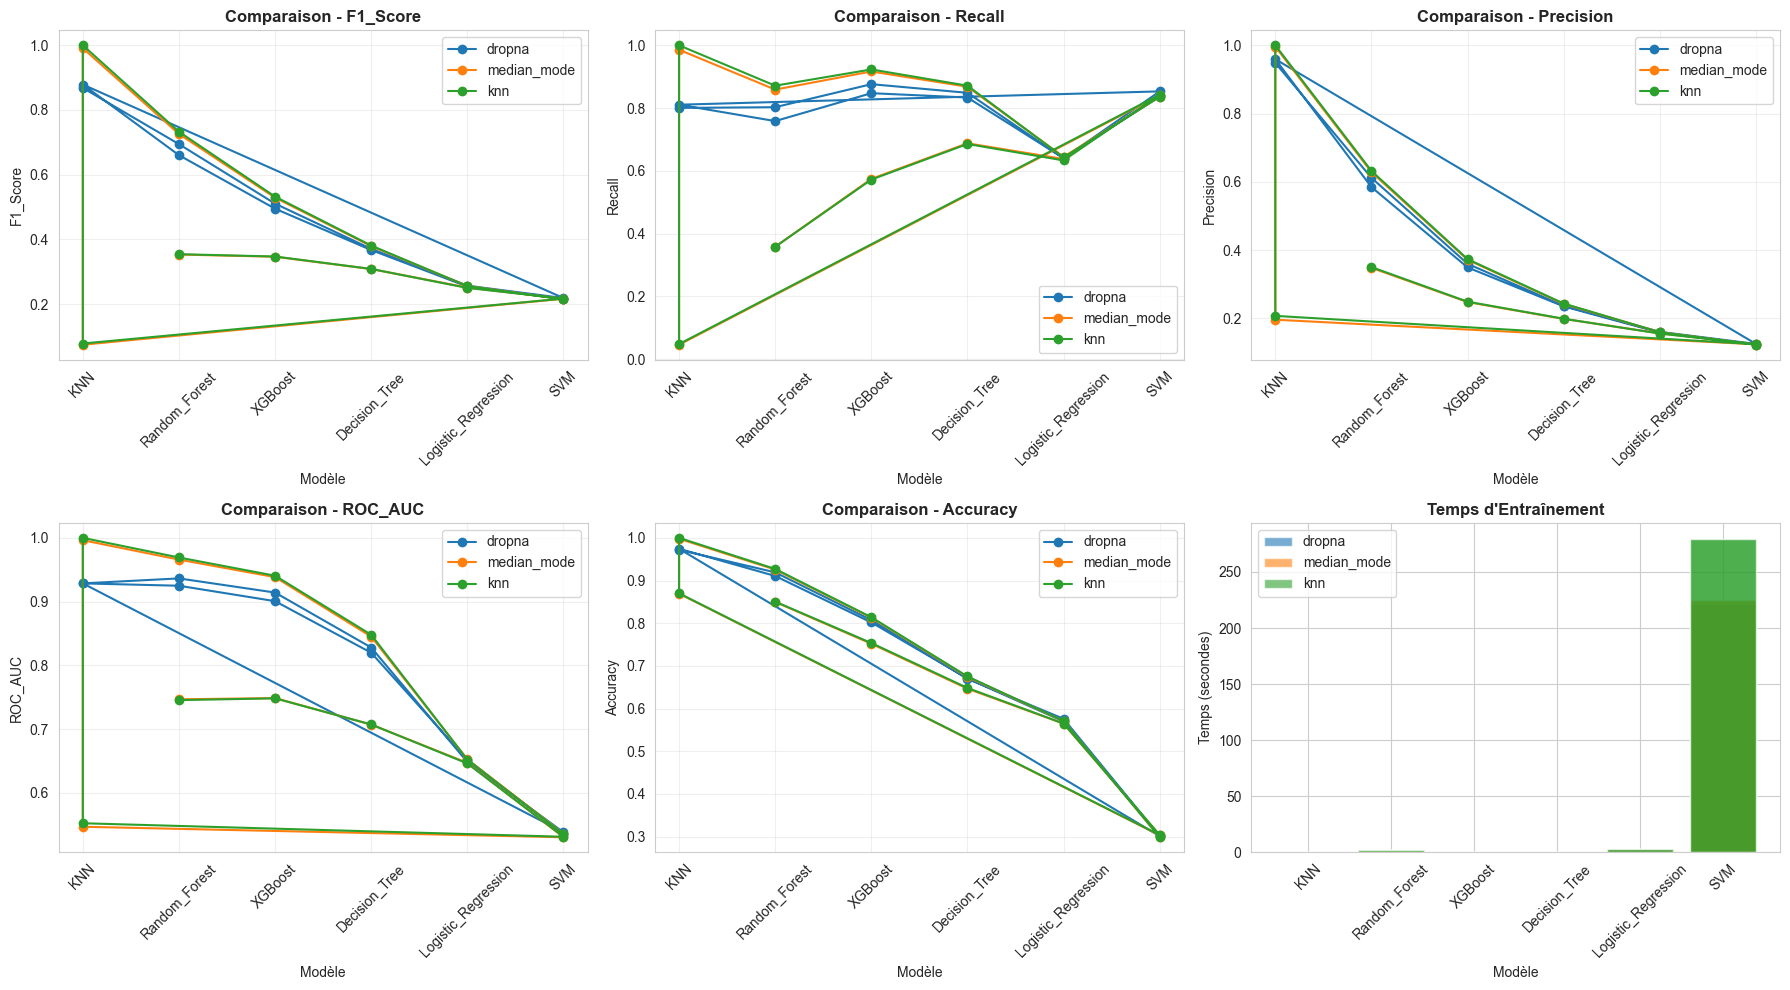

In [121]:
# Préparation des données pour visualisation
metrics_to_plot = ['F1_Score', 'Recall', 'Precision', 'ROC_AUC', 'Accuracy']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx]
    
    # Données par dataset
    for dataset in ['dropna', 'median_mode', 'knn']:
        data = results_df[results_df['Dataset'] == dataset]
        ax.plot(data['Model'], data[metric], marker='o', label=dataset)
    
    ax.set_title(f'Comparaison - {metric}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Modèle', fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

# Temps d'entraînement
ax = axes[5]
for dataset in ['dropna', 'median_mode', 'knn']:
    data = results_df[results_df['Dataset'] == dataset]
    ax.bar(data['Model'], data['Training_Time'], alpha=0.6, label=dataset)

ax.set_title('Temps d\'Entraînement', fontsize=12, fontweight='bold')
ax.set_xlabel('Modèle', fontsize=10)
ax.set_ylabel('Temps (secondes)', fontsize=10)
ax.legend()
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../visualizations/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

5.3 Matrices de Confusion des 3 Meilleurs Modèles

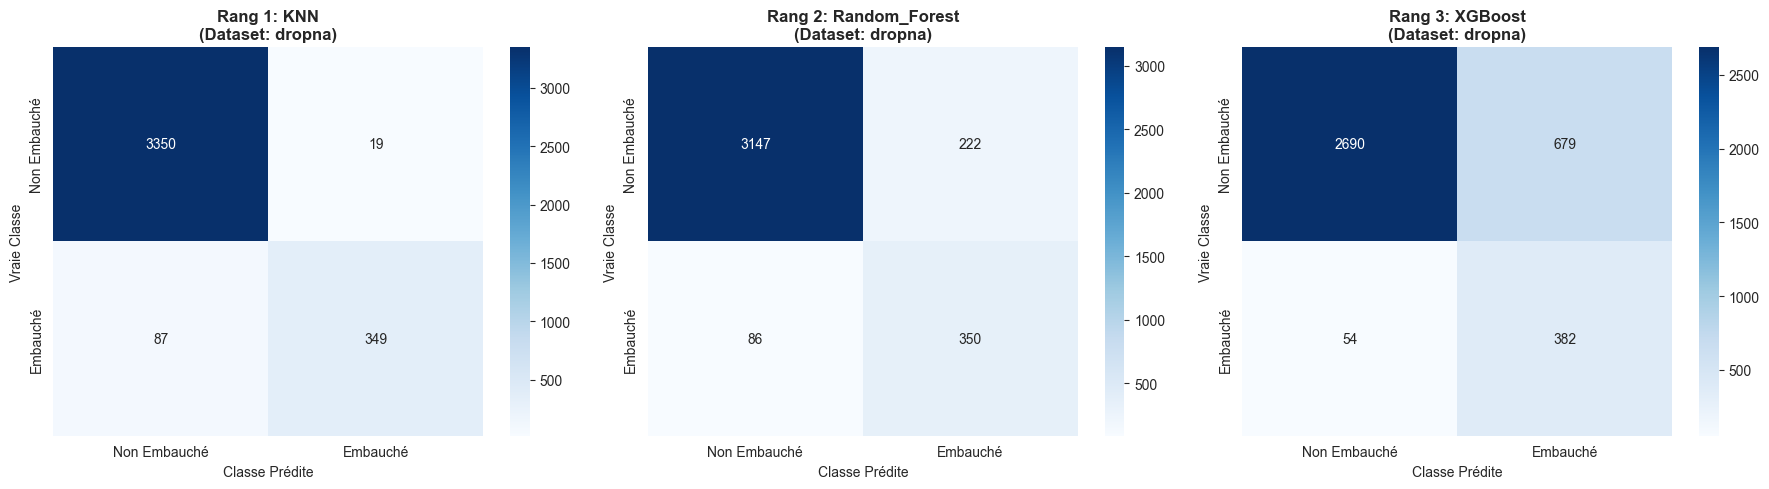

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, info in enumerate(best_models_info):
    dataset = info['dataset']
    model_name = info['model_name']
    rank = info['rank']
    
    cm = all_confusion_matrices[dataset][model_name]
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non Embauché', 'Embauché'],
                yticklabels=['Non Embauché', 'Embauché'])
    
    ax.set_title(f'Rang {rank}: {model_name}\n(Dataset: {dataset})', 
                 fontsize=12, fontweight='bold')
    ax.set_ylabel('Vraie Classe', fontsize=10)
    ax.set_xlabel('Classe Prédite', fontsize=10)

plt.tight_layout()
plt.savefig('../visualizations/top3_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

5.4 Courbes ROC des 3 Meilleurs Modèles

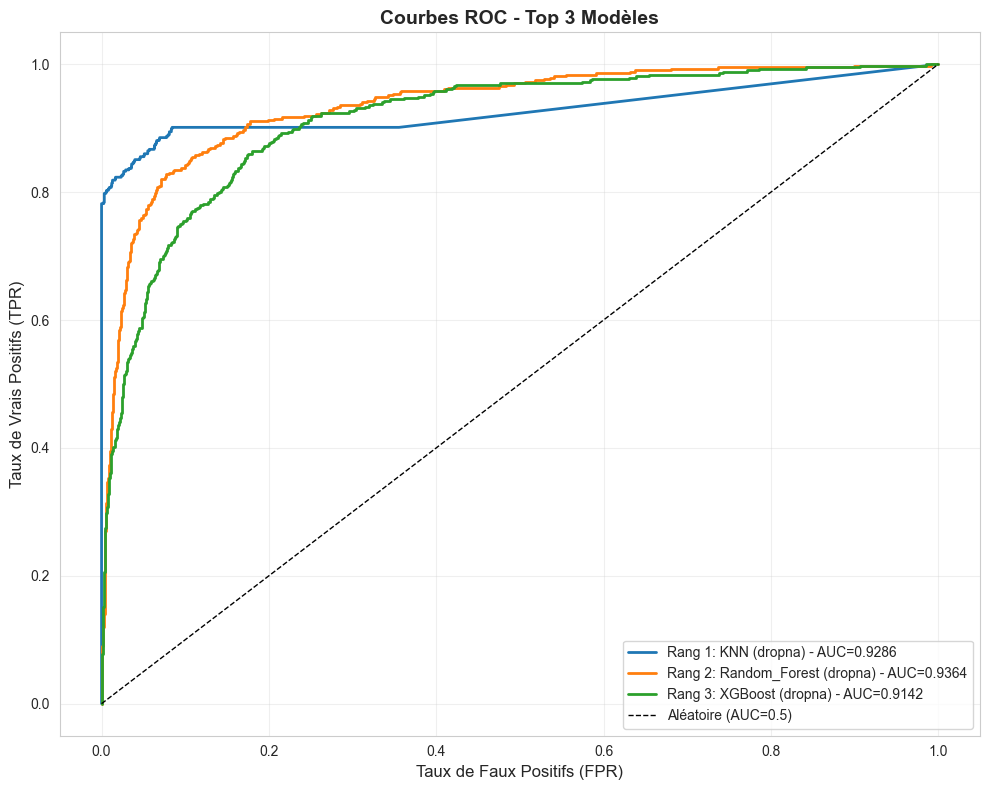

In [123]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(10, 8))

for info in best_models_info:
    dataset = info['dataset']
    model_name = info['model_name']
    rank = info['rank']
    
    y_test = train_test_data[dataset]['y_test']
    y_proba = all_predictions[dataset][model_name]['y_proba']
    
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc_score = roc_auc_score(y_test, y_proba)
        
        plt.plot(fpr, tpr, linewidth=2, 
                label=f'Rang {rank}: {model_name} ({dataset}) - AUC={auc_score:.4f}')

# Ligne de référence
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Aléatoire (AUC=0.5)')

plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbes ROC - Top 3 Modèles', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/top3_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

5.5 Interprétation Métier

In [124]:
print("\n" + "="*80)
print("INTERPRÉTATION MÉTIER DES RÉSULTATS")
print("="*80)

for info in best_models_info:
    dataset = info['dataset']
    model_name = info['model_name']
    rank = info['rank']
    
    row = results_df[(results_df['Dataset'] == dataset) & 
                     (results_df['Model'] == model_name)].iloc[0]
    
    print(f"\nRANG {rank}: {model_name} (Dataset: {dataset})")
    print(f"  F1-Score: {row['F1_Score']:.4f}")
    print(f"  Recall: {row['Recall']:.4f} - Sur 100 candidats embauchables, le modèle en identifie {row['Recall']*100:.1f}")
    print(f"  Precision: {row['Precision']:.4f} - Sur 100 candidats prédits comme embauchables, {row['Precision']*100:.1f} le sont réellement")
    
    cm = all_confusion_matrices[dataset][model_name]
    vp, fp, fn, vn = cm[1,1], cm[0,1], cm[1,0], cm[0,0]
    
    print(f"  Vrais Positifs (VP): {vp} - Candidats correctement identifiés comme embauchables")
    print(f"  Faux Négatifs (FN): {fn} - Talents ratés par le modèle")
    print(f"  Faux Positifs (FP): {fp} - Candidats sélectionnés à tort")
    print(f"  Vrais Négatifs (VN): {vn} - Rejets corrects")


INTERPRÉTATION MÉTIER DES RÉSULTATS

RANG 1: KNN (Dataset: dropna)
  F1-Score: 0.8682
  Recall: 0.8005 - Sur 100 candidats embauchables, le modèle en identifie 80.0
  Precision: 0.9484 - Sur 100 candidats prédits comme embauchables, 94.8 le sont réellement
  Vrais Positifs (VP): 349 - Candidats correctement identifiés comme embauchables
  Faux Négatifs (FN): 87 - Talents ratés par le modèle
  Faux Positifs (FP): 19 - Candidats sélectionnés à tort
  Vrais Négatifs (VN): 3350 - Rejets corrects

RANG 2: Random_Forest (Dataset: dropna)
  F1-Score: 0.6944
  Recall: 0.8028 - Sur 100 candidats embauchables, le modèle en identifie 80.3
  Precision: 0.6119 - Sur 100 candidats prédits comme embauchables, 61.2 le sont réellement
  Vrais Positifs (VP): 350 - Candidats correctement identifiés comme embauchables
  Faux Négatifs (FN): 86 - Talents ratés par le modèle
  Faux Positifs (FP): 222 - Candidats sélectionnés à tort
  Vrais Négatifs (VN): 3147 - Rejets corrects

RANG 3: XGBoost (Dataset: dro

#### 6. VALIDATION CROISÉE

##### 6.1 Configuration de la Cross-Validation

In [125]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, recall_score, precision_score, roc_auc_score
import time
import warnings
warnings.filterwarnings('ignore')

In [126]:
# Paramètres de la validation croisée
N_FOLDS = 5
RANDOM_STATE = 42

#onfiguration du StratifiedKFold
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Définition des métriques à évaluer
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0),
    'roc_auc': 'roc_auc'
}

##### Validation des 3 meilleurs modèles

In [127]:
# Vérification des variables nécessaires
required_vars = ['best_models_info', 'trained_models', 'train_test_data']
missing_vars = [var for var in required_vars if var not in dir()]

if missing_vars:
    print(f"\nATTENTION : Variables manquantes : {missing_vars}")
    print("Ces variables doivent être créées dans les sections précédentes.")
else:
    # Stockage des résultats
    cv_results = []
    
    for info in best_models_info:
        dataset = info['dataset']
        model_name = info['model_name']
        rank = info['rank']
        
        print(f"\n{'='*80}")
        print(f"RANG {rank}: {model_name} (Dataset: {dataset})")
        print(f"{'='*80}")
        
        try:
            # Récupération du modèle et des données
            model = trained_models[dataset][model_name]['model']
            X_train = train_test_data[dataset]['X_train']
            y_train = train_test_data[dataset]['y_train']
            
            print(f"\nDonnées d'entraînement : {X_train.shape[0]} observations, {X_train.shape[1]} features")
            print(f"Distribution de la cible : {dict(pd.Series(y_train).value_counts())}")
            
            # Lancement de la validation croisée
            print(f"\nLancement de la validation croisée ({N_FOLDS} folds)...")
            start_time = time.time()
            
            cv_scores = cross_validate(
                model, 
                X_train, 
                y_train,
                cv=skf,
                scoring=scoring,
                return_train_score=True,
                n_jobs=-1
            )
            
            cv_time = time.time() - start_time
            
            # Calcul des statistiques
            results = {
                'Rank': rank,
                'Dataset': dataset,
                'Model': model_name,
                'CV_Time': cv_time
            }
            
            # Pour chaque métrique, calculer moyenne et écart-type
            for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
                test_scores = cv_scores[f'test_{metric}']
                train_scores = cv_scores[f'train_{metric}']
                
                results[f'{metric}_mean'] = test_scores.mean()
                results[f'{metric}_std'] = test_scores.std()
                results[f'{metric}_train_mean'] = train_scores.mean()
                
                # Détection de l'overfitting
                gap = train_scores.mean() - test_scores.mean()
                results[f'{metric}_gap'] = gap
            
            cv_results.append(results)
            
            # Affichage des résultats
            print(f"\nTemps de validation croisée : {cv_time:.2f} secondes")
            print("\nRésultats de validation croisée (Test Set) :")
            print("-" * 80)
            print(f"  Accuracy  : {results['accuracy_mean']:.4f} (+/- {results['accuracy_std']:.4f})")
            print(f"  Precision : {results['precision_mean']:.4f} (+/- {results['precision_std']:.4f})")
            print(f"  Recall    : {results['recall_mean']:.4f} (+/- {results['recall_std']:.4f})")
            print(f"  F1-Score  : {results['f1_mean']:.4f} (+/- {results['f1_std']:.4f})")
            print(f"  ROC-AUC   : {results['roc_auc_mean']:.4f} (+/- {results['roc_auc_std']:.4f})")
            
            print("\nComparaison Train vs Validation :")
            print("-" * 80)
            print(f"  F1-Score Train      : {results['f1_train_mean']:.4f}")
            print(f"  F1-Score Validation : {results['f1_mean']:.4f}")
            print(f"  Écart (Overfitting) : {results['f1_gap']:.4f}")
            
            if results['f1_gap'] > 0.05:
                print("  >> ATTENTION : Signe d'overfitting détecté (écart > 5%)")
            elif results['f1_gap'] < -0.02:
                print("  >> ATTENTION : Signe d'underfitting détecté (validation > train)")
            else:
                print("  >> Bon équilibre entre train et validation")
                
        except Exception as e:
            print(f"\nERREUR lors de la validation croisée : {e}")
            continue
    
    # Création du DataFrame récapitulatif
    cv_results_df = pd.DataFrame(cv_results)
    
    print("\n" + "="*80)
    print("TABLEAU RÉCAPITULATIF DE LA VALIDATION CROISÉE")
    print("="*80)
    
    # Sélection des colonnes principales pour l'affichage
    display_cols = ['Rank', 'Dataset', 'Model', 'f1_mean', 'f1_std', 
                    'precision_mean', 'recall_mean', 'roc_auc_mean', 'f1_gap']
    
    if len(cv_results_df) > 0:
        print("\n" + cv_results_df[display_cols].to_string(index=False))



RANG 1: KNN (Dataset: dropna)

Données d'entraînement : 15216 observations, 38 features
Distribution de la cible : {0: 13473, 1: 1743}

Lancement de la validation croisée (5 folds)...

ERREUR lors de la validation croisée : 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Papa Magatte Diop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Papa Magatte Diop\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

##### 6.3 Comparaison avec le test set


Comparaison des performances F1-Score :
--------------------------------------------------------------------------------

Rang 2: Random_Forest (dropna)
  F1 Test Set        : 0.6944
  F1 Validation (CV) : 0.4988
  Différence         : 0.1956
  >> ATTENTION : Écart significatif, vérifier le modèle

Rang 3: XGBoost (dropna)
  F1 Test Set        : 0.5104
  F1 Validation (CV) : 0.4816
  Différence         : 0.0288
  >> Bon : Résultats cohérents

Visualisation sauvegardée : test_vs_cv_comparison.png


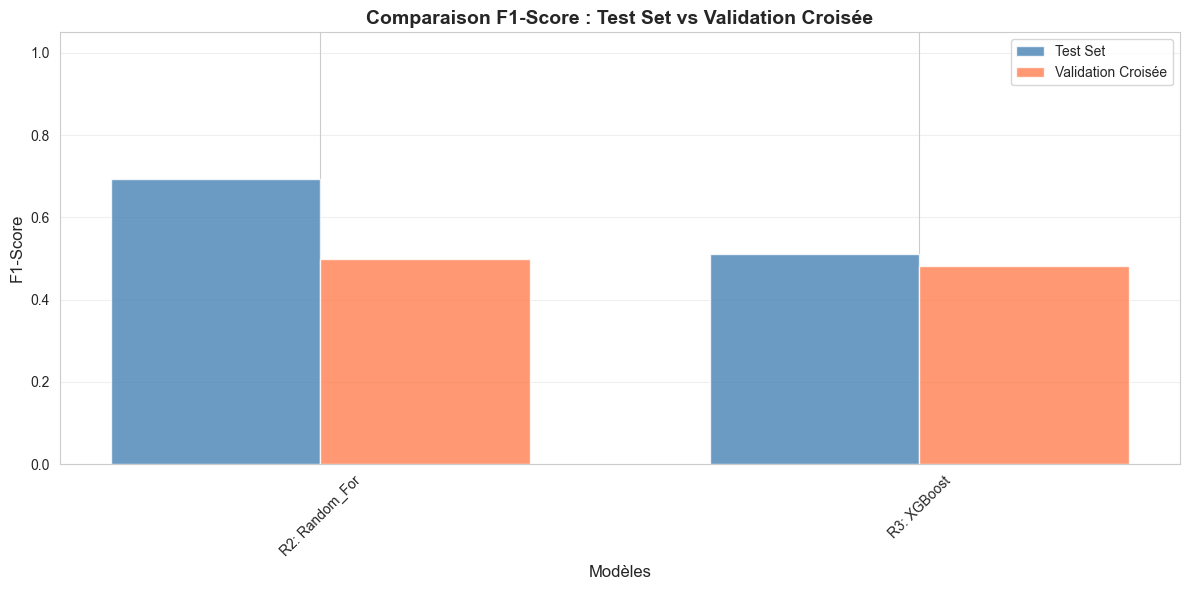

In [128]:
if len(cv_results_df) > 0 and 'results_df' in dir():
    
    print("\nComparaison des performances F1-Score :")
    print("-" * 80)
    
    comparison_data = []
    
    for _, cv_row in cv_results_df.iterrows():
        dataset = cv_row['Dataset']
        model = cv_row['Model']
        
        # Recherche du score test correspondant
        test_row = results_df[(results_df['Dataset'] == dataset) & 
                              (results_df['Model'] == model)]
        
        if len(test_row) > 0:
            test_f1 = test_row.iloc[0]['F1_Score']
            cv_f1 = cv_row['f1_mean']
            difference = abs(test_f1 - cv_f1)
            
            comparison_data.append({
                'Rank': cv_row['Rank'],
                'Model': model,
                'Dataset': dataset,
                'F1_Test': test_f1,
                'F1_CV': cv_f1,
                'Difference': difference
            })
            
            print(f"\nRang {cv_row['Rank']}: {model} ({dataset})")
            print(f"  F1 Test Set        : {test_f1:.4f}")
            print(f"  F1 Validation (CV) : {cv_f1:.4f}")
            print(f"  Différence         : {difference:.4f}")
            
            if difference < 0.02:
                print("  >> Excellent : Résultats très cohérents")
            elif difference < 0.05:
                print("  >> Bon : Résultats cohérents")
            else:
                print("  >> ATTENTION : Écart significatif, vérifier le modèle")
    
    # Visualisation de la comparaison
    if len(comparison_data) > 0:
        comparison_df = pd.DataFrame(comparison_data)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x = np.arange(len(comparison_df))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, comparison_df['F1_Test'], width, 
                      label='Test Set', color='steelblue', alpha=0.8)
        bars2 = ax.bar(x + width/2, comparison_df['F1_CV'], width, 
                      label='Validation Croisée', color='coral', alpha=0.8)
        
        ax.set_xlabel('Modèles', fontsize=12)
        ax.set_ylabel('F1-Score', fontsize=12)
        ax.set_title('Comparaison F1-Score : Test Set vs Validation Croisée', 
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([f"R{r['Rank']}: {r['Model'][:10]}" 
                           for _, r in comparison_df.iterrows()], rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        ax.set_ylim([0, 1.05])
        
        plt.tight_layout()
        plt.savefig('../visualizations/test_vs_cv_comparison.png', dpi=300, bbox_inches='tight')
        print("\nVisualisation sauvegardée : test_vs_cv_comparison.png")
        plt.show()


#### SAUVEGARDE DES MODELES

In [129]:
# =============================================================================
# SAUVEGARDE DES 3 MEILLEURS MODÈLES
# =============================================================================

print("="*80)
print("SAUVEGARDE DES 3 MEILLEURS MODÈLES")
print("="*80)

# Créer le dossier models s'il n'existe pas
if not os.path.exists('../models'):
    os.makedirs('../models')

# Sauvegarder chaque modèle
for info in best_models_info:
    dataset = info['dataset']
    model_name = info['model_name']
    rank = info['rank']
    
    # Récupérer le modèle
    model = trained_models[dataset][model_name]['model']
    
    # Nom du fichier
    filename = f"../models/rank{rank}_{model_name}_{dataset}.pkl"
    
    # Sauvegarder
    joblib.dump(model, filename)
    
    print(f"Rank {rank} sauvegardé : {filename}")

print("\nSauvegarde terminée")

SAUVEGARDE DES 3 MEILLEURS MODÈLES
Rank 1 sauvegardé : ../models/rank1_KNN_dropna.pkl
Rank 2 sauvegardé : ../models/rank2_Random_Forest_dropna.pkl
Rank 3 sauvegardé : ../models/rank3_XGBoost_dropna.pkl

Sauvegarde terminée
